### Module 6.2 Assignment: Preparing Data for Final Team Project
#### Trevor Sauerbrey, Stephen Reagin, Bryan Flores

In [3]:
# Imports
import requests  
from bs4 import BeautifulSoup  
import pandas as pd  
import io  
from PyPDF2 import PdfReader  
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words("english")
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trevor.sauerbrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trevor.sauerbrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def fetch_arxiv_data(search_query, max_results=10, start_date=None, end_date=None, primary_category=None, categories=None):
    """
    Fetches data from the arXiv API based on specified parameters.

    Parameters:
        search_query (str): The search query string.
        max_results (int): The maximum number of results to retrieve (default is 10).
        start_date (str): The start date for the search query in the format 'YYYY-MM-DD'.
        end_date (str): The end date for the search query in the format 'YYYY-MM-DD'.
        primary_category (str): The primary category of the articles.
        categories (str): Additional categories for the articles.

    Returns:
        DataFrame: A pandas DataFrame containing the fetched arXiv data.
    """
    api_url = "http://export.arxiv.org/api/query"  # Defining the API URL for arXiv
    params = {
        "search_query": search_query,  # Setting search query parameter
        "start": 0,  # Setting start parameter for pagination
        "max_results": max_results,  # Setting maximum results parameter
    }
    if start_date:
        params["start_date"] = start_date  # Adding start date parameter if provided
    if end_date:
        params["end_date"] = end_date  # Adding end date parameter if provided
    if primary_category:
        params["cat"] = primary_category  # Adding primary category parameter if provided
    if categories:
        params["categories"] = categories  # Adding additional categories parameter if provided

    response = requests.get(api_url, params=params)  # Making a GET request to arXiv API with specified parameters
    if response.status_code == 200:  # Checking if the request was successful
        feed = BeautifulSoup(response.content, features="html.parser")  # Parsing the response content using BeautifulSoup
        entries = feed.find_all('entry')  # Finding all 'entry' elements in the parsed content
        articles = []

        for entry in entries:  # Looping through each entry
            article = {}  # Creating an empty dictionary to store article data
            article['Title'] = entry.title.text  # Extracting title of the article
            article['Authors'] = [author.find('name').text for author in entry.find_all('author')]  # Extracting authors of the article
            article['Published'] = entry.published.text  # Extracting publication date
            article['Updated'] = entry.updated.text  # Extracting last updated date
            article['Summary'] = entry.summary.text.strip()  # Extracting summary of the article
            article['ID'] = entry.id.text  # Extracting unique ID of the article
            articles.append(article)  # Appending article data to the list

        df = pd.DataFrame(articles)  # Creating a pandas DataFrame from the list of articles
        return df  # Returning the DataFrame
    else:
        print("Failed to retrieve data from arXiv API")  # Printing error message if request fails
        return None

def download_pdf_from_link(link):
    """
    Downloads a PDF file from the given URL.

    Parameters:
        link (str): The URL of the PDF file.

    Returns:
        io.BytesIO or None: BytesIO object containing the PDF content if successful, else None.
    """
    response = requests.get(link, stream=True)  # Making a GET request to download the PDF file
    if response.status_code == 200:  # Checking if the request was successful
        return io.BytesIO(response.content)  # Returning BytesIO object containing the PDF content
    else:
        print(f"Failed to download PDF from {link}")  # Printing error message if download fails
        return None

def extract_text_from_pdf(pdf_io):
    """
    Extracts text from a PDF file.

    Parameters:
        pdf_io (io.BytesIO): BytesIO object containing the PDF content.

    Returns:
        str: Extracted text from the PDF.
    """
    if pdf_io:
        try:
            reader = PdfReader(pdf_io)  # Creating a PdfReader object with the PDF content
            text = ""
            for page in reader.pages:  # Looping through each page in the PDF
                text += page.extract_text() + "\n"  # Extracting text from the page and appending it to the 'text' variable
            return text  # Returning the extracted text
        except Exception as e:
            print(f"Error occurred while extracting text from PDF: {str(e)}")  # Printing error message if extraction fails
            return ""

def process_pdf_links(df):
    """
    Processes PDF links in a DataFrame by downloading and extracting text from them.

    Parameters:
        df (DataFrame): The pandas DataFrame containing PDF links.

    Returns:
        DataFrame: The DataFrame with an additional column containing extracted text from PDFs.
    """
    df['PDF_Text'] = ''  # Adding an empty column 'PDF_Text' to the DataFrame
    for index, row in df.iterrows():  # Looping through each row in the DataFrame
        link = row['ID']  # Extracting the PDF link from the 'ID' column
        # We need to convert the '/abs/' URL to a '/pdf/' URL and ensure it ends with '.pdf'
        link = link.replace('abs', 'pdf')  # Replacing 'abs' with 'pdf' in the URL
        if not link.endswith('.pdf'):  # Checking if the link ends with '.pdf'
            link += '.pdf'  # Appending '.pdf' to the link if it doesn't end with it already
        print(f"Processing link: {link}")  # Printing the processed link
        pdf_io = download_pdf_from_link(link)  # Downloading the PDF file
        if pdf_io:  # Checking if PDF download was successful
            text = extract_text_from_pdf(pdf_io)  # Extracting text from the PDF
            df.at[index, 'PDF_Text'] = text  # Adding the extracted text to the 'PDF_Text' column in the DataFrame
    return df  # Returning the updated DataFrame

def preprocess_text(text):
    """
    Preprocesses the text by converting it to lowercase, removing digits, and removing punctuation.

    Parameters:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

def remove_stopwords(tokens):
    """
    Removes stopwords from the list of tokens.

    Parameters:
        tokens (list): List of tokens.

    Returns:
        list: Tokens with stopwords removed.
    """
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words] 
    return filtered_tokens 

def perform_lemmatization(tokens):
    """
    Performs lemmatization on the list of tokens.

    Parameters:
        tokens (list): List of tokens.

    Returns:
        list: Lemmatized tokens.
    """
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def clean_text(text):
    """
    Cleans the text by preprocessing, removing stopwords, and performing lemmatization.

    Parameters:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    # Preprocess the text
    text = preprocess_text(text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = remove_stopwords(tokens)
    
    # Perform lemmatization
    lemmatized_tokens = perform_lemmatization(filtered_tokens)
    
    # Join the lemmatized tokens into a string
    cleaned_text = ' '.join(lemmatized_tokens)
    
    return cleaned_text

def clean_and_tokenize(text):
    """
    Cleans and tokenizes the given text.

    Parameters:
        text (str): The input text to be cleaned and tokenized.

    Returns:
        list: The list of cleaned and tokenized words.
    """
    if text is None:
        return []  # Return an empty list if the text is None
    
    # Remove punctuation characters
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    return tokens

def descriptive_stats(tokens_list, num_tokens=5, verbose=True):
    """
    Given a list of lists of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a list with the number of tokens, number of unique tokens,
    lexical diversity, and number of characters.

    """

    # Flatten the list of lists into a single list
    tokens = [token for sublist in tokens_list for token in sublist]
    
    # Fill in the correct values here.
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    
    # Check if num_tokens is zero to avoid ZeroDivisionError
    if num_tokens == 0:
        return [0, 0, 0.0, 0]  # Return appropriate values when there are no tokens
    
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum([len(token) for token in tokens])

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

    # print the five most common tokens

    return [num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters]

In [5]:
# Example usage
df = fetch_arxiv_data(search_query="quantum physics", max_results=100, primary_category="quant-ph", categories=["quant-ph"])
df_with_pdf_text = process_pdf_links(df)
df_with_pdf_text

Processing link: http://arxiv.org/pdf/quant-ph/0302169v1.pdf
Processing link: http://arxiv.org/pdf/1212.4177v1.pdf
Processing link: http://arxiv.org/pdf/1504.03207v1.pdf
Processing link: http://arxiv.org/pdf/2208.08064v1.pdf
Processing link: http://arxiv.org/pdf/cond-mat/0601285v1.pdf
Processing link: http://arxiv.org/pdf/0811.2516v1.pdf
Processing link: http://arxiv.org/pdf/1807.11019v1.pdf
Processing link: http://arxiv.org/pdf/quant-ph/0201082v1.pdf
Processing link: http://arxiv.org/pdf/quant-ph/0309066v1.pdf
Processing link: http://arxiv.org/pdf/quant-ph/0504224v1.pdf
Processing link: http://arxiv.org/pdf/quant-ph/0703105v1.pdf
Processing link: http://arxiv.org/pdf/2111.15352v4.pdf
Processing link: http://arxiv.org/pdf/1704.07976v1.pdf
Processing link: http://arxiv.org/pdf/1310.8457v1.pdf
Processing link: http://arxiv.org/pdf/quant-ph/0407102v1.pdf
Processing link: http://arxiv.org/pdf/0804.3401v1.pdf
Processing link: http://arxiv.org/pdf/1611.03472v1.pdf
Processing link: http://arx

,Title,Authors,Published,Updated,Summary,ID,PDF_Text
0,Nonlinear Dynamics In Quantum Physics -- Quant...,[H. Kröger],2003-02-21T20:20:47Z,2003-02-21T20:20:47Z,We discuss the recently proposed quantum actio...,http://arxiv.org/abs/quant-ph/0302169v1,arXiv:quant-ph/0302169v1 21 Feb 2003PROCEEDIN...
1,Quantum spherical model,[I. Lyberg],2012-12-17T22:06:56Z,2012-12-17T22:06:56Z,"We define a ""quantum spherical model"", a quant...",http://arxiv.org/abs/1212.4177v1,arXiv:1212.4177v1 [math-ph] 17 Dec 2012A “qu...
2,Can classical physics agree with quantum physi...,[Michele Marrocco],2015-04-13T15:04:26Z,2015-04-13T15:04:26Z,Classical physics fails where quantum physics ...,http://arxiv.org/abs/1504.03207v1,1 Can classical physics agree with quant um p...


In [6]:
df_with_pdf_text['pdf_tokens'] = df_with_pdf_text['PDF_Text'].apply(clean_and_tokenize)
df_with_pdf_text.head(3)

,Title,Authors,Published,Updated,Summary,ID,PDF_Text,pdf_tokens
0,Nonlinear Dynamics In Quantum Physics -- Quant...,[H. Kröger],2003-02-21T20:20:47Z,2003-02-21T20:20:47Z,We discuss the recently proposed quantum actio...,http://arxiv.org/abs/quant-ph/0302169v1,arXiv:quant-ph/0302169v1 21 Feb 2003PROCEEDIN...,"[arXivquantph0302169v1, 21, Feb, 2003PROCEEDIN..."
1,Quantum spherical model,[I. Lyberg],2012-12-17T22:06:56Z,2012-12-17T22:06:56Z,"We define a ""quantum spherical model"", a quant...",http://arxiv.org/abs/1212.4177v1,arXiv:1212.4177v1 [math-ph] 17 Dec 2012A “qu...,"[arXiv12124177v1, mathph, 17, Dec, 2012A, “, q..."
2,Can classical physics agree with quantum physi...,[Michele Marrocco],2015-04-13T15:04:26Z,2015-04-13T15:04:26Z,Classical physics fails where quantum physics ...,http://arxiv.org/abs/1504.03207v1,1 Can classical physics agree with quant um p...,"[1, classical, physics, agree, quant, um, phys..."


In [7]:
# Apply descriptive_stats function to pdf_tokens column
stats = descriptive_stats(df_with_pdf_text['pdf_tokens'])

# Print the descriptive statistics
print("Descriptive Statistics for pdf_tokens:")
print(f"Number of Tokens: {stats[0]}")
print(f"Number of Unique Tokens: {stats[1]}")
print(f"Lexical Diversity: {stats[2]:.3f}")
print(f"Number of Characters: {stats[3]}")

There are 979965 tokens in the data.
There are 110857 unique tokens in the data.
There are 6236040 characters in the data.
The lexical diversity is 0.113 in the data.
Descriptive Statistics for pdf_tokens:
Number of Tokens: 979965
Number of Unique Tokens: 110857
Lexical Diversity: 0.113
Number of Characters: 6236040


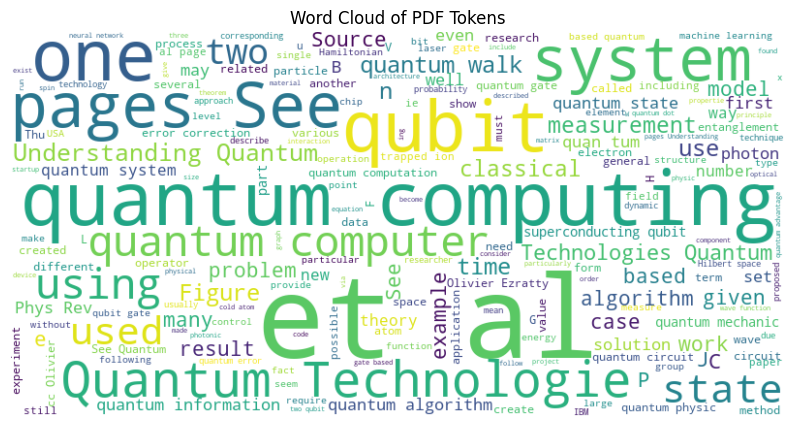

In [8]:
# Combine all tokens into a single string
all_tokens = ' '.join(df_with_pdf_text['pdf_tokens'].sum())

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of PDF Tokens')
plt.show()

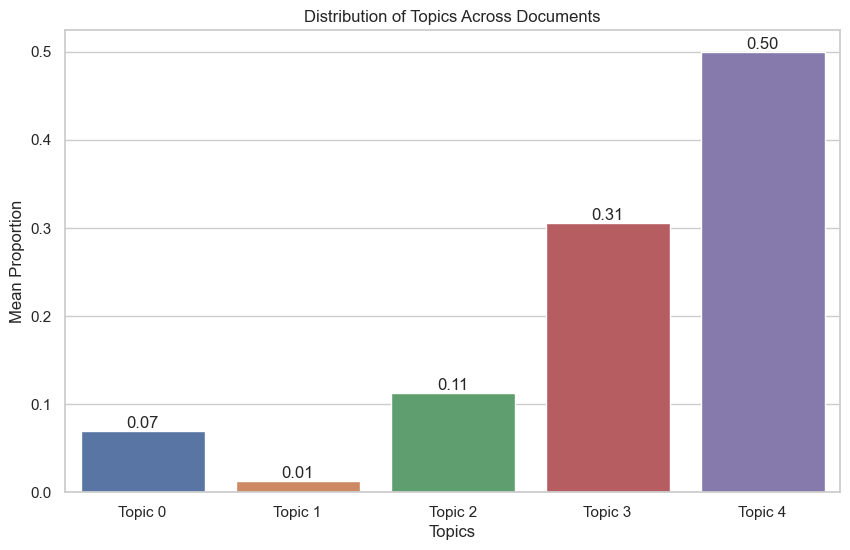

In [9]:
# Vectorize the text data
vectorizer = CountVectorizer(max_features=5000, max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df_with_pdf_text['PDF_Text'])

# Apply LDA
num_topics = 5  # You can adjust the number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Visualize the distribution of topics across documents
topic_distribution = lda.transform(X)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[f"Topic {i}" for i in range(num_topics)], y=topic_distribution.mean(axis=0))
plt.title('Distribution of Topics Across Documents')
plt.xlabel('Topics')
plt.ylabel('Mean Proportion')

# Add numbers to the bars
for i, mean_proportion in enumerate(topic_distribution.mean(axis=0)):
    ax.text(i, mean_proportion, f'{mean_proportion:.2f}', ha='center', va='bottom')

plt.show()